# RBIG Demo

In [35]:
%matplotlib inline
import sys

sys.path.insert(0, '/home/emmanuel/code/py_packages/rbig/src')
sys.path.insert(0, '/home/emmanuel/Drives/megatron/temp/2017_RBIG/')
sys.path.insert(0, '/Users/eman/Documents/code_projects/rbig/')
import numpy as np
import seaborn as sns
import pandas as pd
import warnings
from time import time
from rbig.rbig import RBIG
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state
from scipy import io

import matplotlib.pyplot as plt
plt.style.use('ggplot')
warnings.filterwarnings('ignore') # get rid of annoying warnings

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Toy Data

In [2]:
seed = 123
rng = np.random.RandomState(seed=seed)
aux2 = io.loadmat('/Users/eman/Documents/MATLAB/rbig_2018/DATA_uniform_dim_10_seed_2.mat')



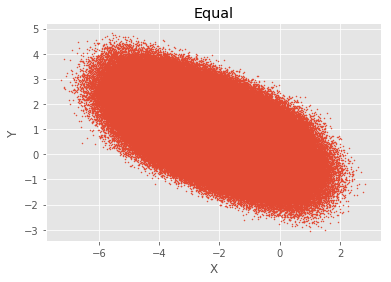

In [3]:
seed = 123
rng = np.random.RandomState(seed=seed)
aux2 = io.loadmat('/Users/eman/Documents/MATLAB/rbig_2018/DATA_uniform_dim_10_seed_2.mat')

# aux2 = io.loadmat('/home/emmanuel/Drives/megatron/temp/2017_RBIG/DATA_uniform_dim_10_seed_2.mat')
data = aux2['dat'].T
data_original = aux2['aux'].T
R = aux2['R'].T
# num_samples = 10000
# x = np.abs(2 * rng.randn(1, num_samples))
# y = np.sin(x) + 0.25 * rng.randn(1, num_samples)
# data = np.vstack((x, y)).T

fig, ax = plt.subplots()
ax.scatter(data[:, 0], data[:, 1], s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Equal')
plt.show()

In [4]:
data_aux = np.dot(data_original, R)

## RBIG Fitting

In [5]:
%%time

n_layers = 5
rotation_type = 'PCA'
random_state = 123
pdf_extension = 0.1
pdf_resolution = 1000

# Initialize RBIG class
rbig_model = RBIG(n_layers=n_layers, rotation_type=rotation_type, random_state=random_state, 
                  pdf_extension=0.1, pdf_resolution=100)

# fit model to the data
rbig_model.fit(data);

CPU times: user 13.6 s, sys: 1.47 s, total: 15 s
Wall time: 14.4 s


(1000, 10, 10)


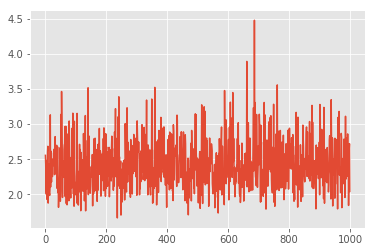

In [6]:
ndet = 1000

jacobian = rbig_model.jacobian(data[:ndet, :])
print(jacobian.shape)
dd = np.zeros(ndet)

for i in range(ndet):
    aux = jacobian[i, ...].squeeze()
    dd[i] = np.abs(np.linalg.det(aux))
    
fig, ax = plt.subplots()
ax.plot(np.log10(dd))
plt.show()

fig_loc = '/Users/eman/Desktop/'
save_name = 'test_rbig_py.png'
fig.savefig(fig_loc + save_name)

### Checking Versus MATLAB Results

In [32]:
# load data
matlab_results = io.loadmat('/Users/eman/Documents/MATLAB/rbig_2018/test_results_matlab.mat')['dd'].squeeze()
py_results = dd

(1000,) (1000,)


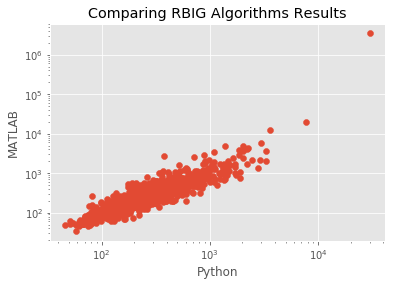

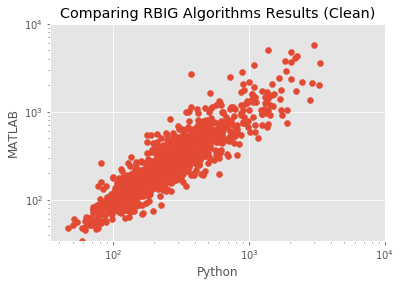

In [33]:




x_min = np.minimum(matlab_results.min(), py_results.min())
x_max = np.maximum(matlab_results.max(), py_results.max())

print(py_results.shape, matlab_results.shape)

fig, ax = plt.subplots()

ax.scatter(py_results, matlab_results)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title('Comparing RBIG Algorithms Results')
ax.set_xlabel('Python')
ax.set_ylabel('MATLAB')

plt.show()

fig_loc = '/Users/eman/Desktop/'
save_name = 'test_mat_v_py.png'
fig.savefig(fig_loc + save_name)





fig, ax = plt.subplots()

ax.scatter(py_results, matlab_results)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([x_min, 10**4])
ax.set_ylim([x_min, 10**4])
ax.set_title('Comparing RBIG Algorithms Results (Clean)')
ax.set_xlabel('Python')
ax.set_ylabel('MATLAB')

plt.show()

fig_loc = '/Users/eman/Desktop/'
save_name = 'test_mat_v_py_clean.png'
fig.savefig(fig_loc + save_name)

In [39]:
data = pd.DataFrame({
    'x': matlab_results, 
    'y': py_results})

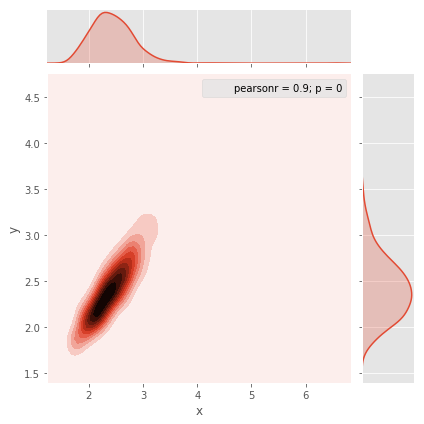

In [46]:
sns_plot = sns.jointplot(x="x", y="y", data=np.log10(data), kind="kde")
fig_loc = '/Users/eman/Desktop/'
save_name = 'test_mat_v_py_jointplot.png'
sns_plot.savefig(fig_loc + save_name)
# ax = g.ax_joint
# ax.set_xscale('log')
# ax.set_yscale('log')

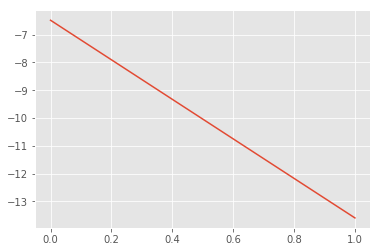

In [19]:
jacobian, data_transform2 = rbig_model.jacobian(data[:1000, :])

ndet = 1000
# dd = np.zeros(jacobian.shape[1])
for i in range(jacobian.shape[1]):
    dd[i] = np.linalg.det(jacobian[i, :, :])
    
# fig, ax = plt.subplots()
# ax.plot(dd)
# plt.show()

### Transform Data into Gaussian

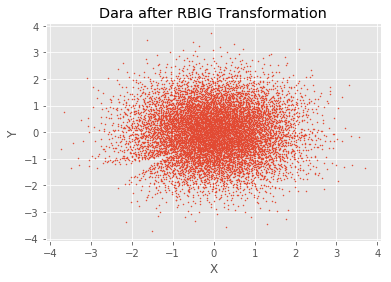

In [5]:
# transform data
data_trans = rbig_model.transform(data)

fig, ax = plt.subplots()
ax.scatter(data_trans[:, 0], data_trans[:, 1], s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Dara after RBIG Transformation')
plt.show()

## BUCLE

In [23]:
%%time 

n_layers = 1000
rotation_type = 'PCA'
random_state = 123
pdf_extension = 0.1
pdf_resolution = 1000
n_samples = 10000

R = np.array([[10, 0.5, 1, 7], [50, -3, 5, -5], [2, -3, 5, 4], [-2, -3, 5, 4]])
MIS = np.zeros(100)

for i in range(100):
    aux = np.random.rand(n_samples, 4)
    dat = np.dot(aux, R)
    rbig_model = RBIG(n_layers=n_layers, rotation_type=rotation_type, pdf_extension=pdf_extension,
                      pdf_resolution=pdf_resolution)
    g_data = rbig_model.fit(dat).transform(dat)
    
    di = rbig_model.residual_info
    
    MIS[i] = sum(di)
    print(i)

# # Initialize RBIG class
# rbig_model = RBIG(n_layers=n_layers, rotation_type=rotation_type, random_state=random_state, 
#                   pdf_extension=0.1, pdf_resolution=100)

# # fit model to the data
# rbig_model.fit(data);

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


KeyboardInterrupt: 

AttributeError: 'AxesSubplot' object has no attribute 'show'

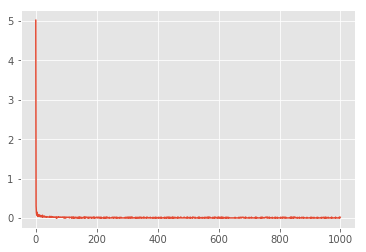

In [24]:
fig, ax = plt.subplots()

ax.plot(di)
ax.show()

AttributeError: 'AxesSubplot' object has no attribute 'show'

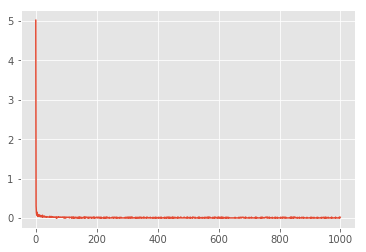

In [25]:
fig, ax = plt.subplots()

ax.plot(di)
ax.show(MIS)

In [ ]:
print(MIS.mean(), MIS.std())